In [1]:
import os
import pandas as pd

### 미세먼지 수치가 중국 지수의 선행 지표가 될 수 있는지 검증해보자

In [2]:
# 서울시 기간별 일평균 대기환경 정보
# https://data.seoul.go.kr/dataList/OA-2220/F/1/datasetView.do
def read_data(path, encoding='euc-kr'):
    if path.endswith('xlsx'):
        df = pd.read_excel(path, encoding=encoding)
    else: # csv
        df = pd.read_csv(path, encoding=encoding)
    df['측정일자'] = df['측정일자'].apply(lambda x: pd.to_datetime(str(x)))
    return df
    
def aggregate_by_date(df):
    df = df[['측정일자', '미세먼지(㎍/㎥)']]
    df = df.groupby('측정일자').agg('mean')
    return df

In [3]:
fine_dust_data = []

for path in os.listdir('./'):
    if path.startswith('기간별_일평균_대기환경_정보'):
        df = read_data(path)
        df = aggregate_by_date(df)
        fine_dust_data.append(df)
        
fine_dust_data = pd.concat(fine_dust_data, axis=0, sort=True).sort_index()

In [4]:
fine_dust_data.head()

,미세먼지(㎍/㎥)
측정일자,
2015-01-01,66.40
2015-01-02,29.04
2015-01-03,36.72
2015-01-04,42.16
2015-01-05,76.24


In [5]:
import FinanceDataReader as fdr

kospi = fdr.DataReader('KS11', '2015-01-01', '2018-12-31') # 코스피
csi300 = fdr.DataReader('CSI300', '2015-01-01', '2018-12-31') # 중국 CSI300

In [6]:
kospi.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2015-01-02,1926.44,1914.24,1929.15,1909.67,258780000.0,0.0057
2015-01-05,1915.75,1921.96,1921.96,1903.37,313440000.0,-0.0055
2015-01-06,1882.45,1895.48,1900.02,1877.38,303690000.0,-0.0174
2015-01-07,1883.83,1878.90,1887.60,1876.27,280510000.0,0.0007
2015-01-08,1904.65,1895.85,1907.23,1891.77,262210000.0,0.0111


In [7]:
csi300.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2015-01-05,3641.54,3566.09,3669.04,3551.51,451200.0,0.0305
2015-01-06,3641.06,3608.43,3683.23,3587.23,420960.0,-0.0001
2015-01-07,3643.79,3620.92,3671.19,3601.70,320190.0,0.0007
2015-01-08,3559.26,3650.07,3659.95,3552.10,295000.0,-0.0232
2015-01-09,3546.72,3547.57,3689.75,3536.39,349980.0,-0.0035


In [8]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

/Users/wook/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


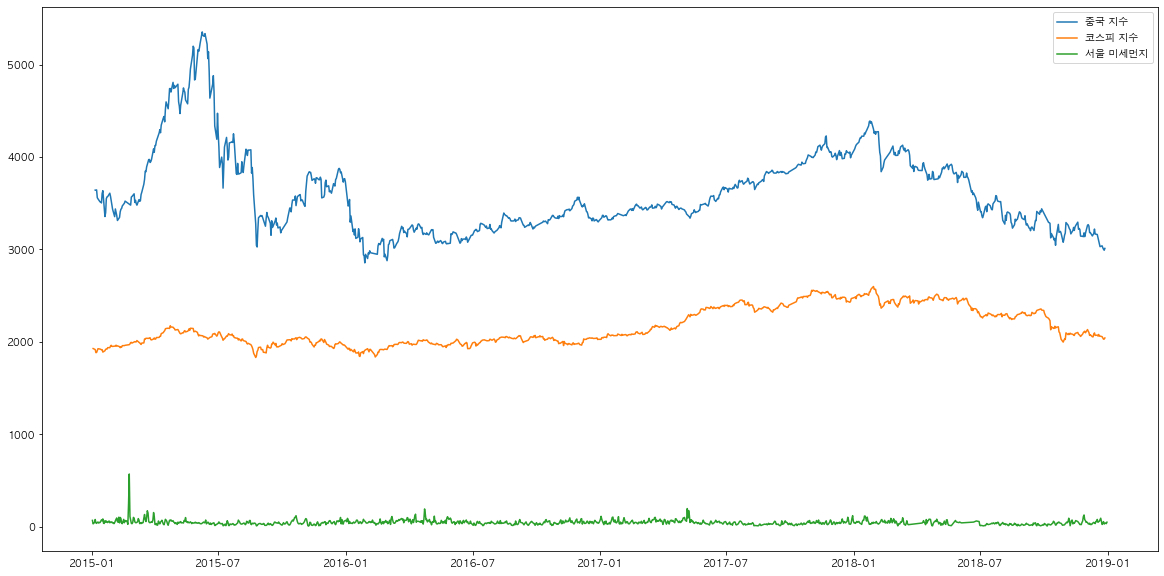

In [9]:
plt.figure(figsize=(20,10))
plt.plot(csi300['Close'], label='중국 지수')
plt.plot(kospi['Close'], label='코스피 지수')
plt.plot(fine_dust_data['미세먼지(㎍/㎥)'], label='서울 미세먼지')
plt.legend(loc='upper right')

### 스케일이 달라 비교하기 힘드니 스케일링 해주자

In [10]:
def min_max_scale(column):
    # 0 이상 1 이하 값으로 스케일링
    _min = column.min()
    _max = column.max()
    column = column.apply(lambda x: (x - _min) / (_max - _min))
    return column

In [11]:
min_max_scale(csi300['Close']).head()

Date
2015-01-05    0.315113
2015-01-06    0.314921
2015-01-07    0.316013
2015-01-08    0.282201
2015-01-09    0.277185
Name: Close, dtype: float64

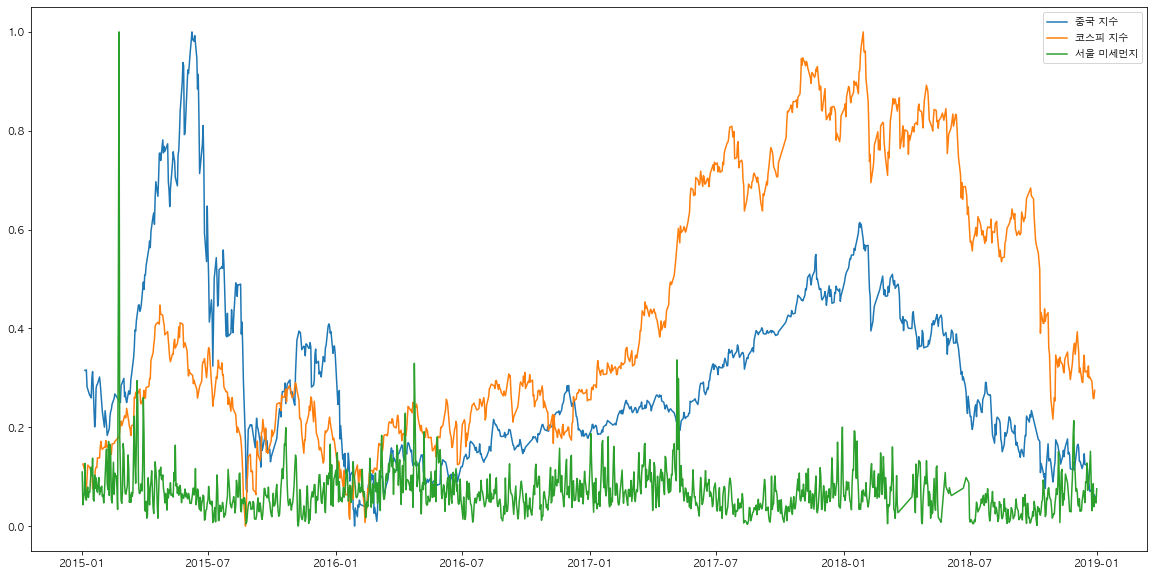

In [12]:
plt.figure(figsize=(20,10))
plt.plot(min_max_scale(csi300['Close']), label='중국 지수')
plt.plot(min_max_scale(kospi['Close']), label='코스피 지수')
plt.plot(min_max_scale(fine_dust_data['미세먼지(㎍/㎥)']), label='서울 미세먼지')
plt.legend(loc='upper right')

In [14]:
fine_dust_data['이동평균'] = fine_dust_data['미세먼지(㎍/㎥)'].rolling(window=30).agg('mean')
fine_dust_data['이동표준편차'] = fine_dust_data['미세먼지(㎍/㎥)'].rolling(window=30).agg('std')
fine_dust_data['미세먼지_증가'] = (fine_dust_data['미세먼지(㎍/㎥)'] > fine_dust_data['이동평균'])
fine_dust_data['시그마'] = ((fine_dust_data['미세먼지(㎍/㎥)']  - fine_dust_data['이동평균']) / fine_dust_data['이동표준편차'])

In [15]:
fine_dust_data.tail()

,미세먼지(㎍/㎥),이동평균,이동표준편차,미세먼지_증가,시그마
측정일자,,,,,
2018-12-27,26.68,48.132000,22.966961,False,-0.934037
2018-12-28,34.92,45.129333,17.900438,False,-0.570340
2018-12-29,38.32,43.942667,17.087567,False,-0.329050
2018-12-30,31.00,42.830667,16.796051,False,-0.704372
2018-12-31,47.24,42.920000,16.812685,True,0.256949


In [16]:
agg_data = fine_dust_data[['시그마', '미세먼지_증가']]

In [17]:
agg_data.loc[:, '중국지수'] = csi300['Close'].copy()
agg_data.loc[:, '중국지수'] = agg_data['중국지수'].fillna(method='ffill').copy() # 개장 안한날 Null값은 직전 데이터로 보정

/Users/wook/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/wook/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
n_days = [1,3,7,10,20,30,60,90]

In [19]:
for n in n_days:
    agg_data.loc[:, '중국지수_{}일후'.format(n)] = agg_data['중국지수'].shift(periods=-n).copy()

In [20]:
for n in n_days:
    agg_data.loc[:, '중국지수_{}일후_수익률'.format(n)] = \
        (agg_data['중국지수_{}일후'.format(n)] - agg_data['중국지수']) / agg_data['중국지수']

In [21]:
agg_data = agg_data.dropna()

In [28]:
from scipy.stats import hmean

def get_performance(df, sigma):
    return_cols = [col for col in df.columns if '수익률' in col]
    if sigma >= 0:
        print('[{} 시그마 이상 미세먼지 증가한 경우]'.format(sigma))
        filter_cond = (df['시그마'] >= sigma)
    else:
        print('[{} 시그마 이하 미세먼지 하락한 경우]'.format(sigma))
        filter_cond = (df['시그마'] < sigma)
        
    print('전체데이터 중 해당되는 케이스 비율:{:.3f} ({}/{})'.format(filter_cond.mean(), filter_cond.sum(), len(df)))
    print('====== 산술 수익률 ======')
    for col in return_cols:
        print('{}: {:.3f}'.format(col, df.loc[filter_cond][col].mean(axis=0)))
    print('====== 기하 수익률 ======')
    for col in return_cols:
        print('{}: {:.3f}'.format(col, hmean(df.loc[filter_cond][col] + 1) - 1))

In [29]:
get_performance(agg_data, sigma=1)

[1 시그마 이상 미세먼지 증가한 경우]
전체데이터 중 해당되는 케이스 비율:0.155 (199/1282)
====== 산술 수익률 ======
중국지수_1일후_수익률: -0.000
중국지수_3일후_수익률: 0.001
중국지수_7일후_수익률: 0.002
중국지수_10일후_수익률: 0.002
중국지수_20일후_수익률: 0.001
중국지수_30일후_수익률: -0.001
중국지수_60일후_수익률: 0.003
중국지수_90일후_수익률: 0.003
====== 기하 수익률 ======
중국지수_1일후_수익률: -0.000
중국지수_3일후_수익률: 0.000
중국지수_7일후_수익률: 0.001
중국지수_10일후_수익률: -0.000
중국지수_20일후_수익률: -0.003
중국지수_30일후_수익률: -0.007
중국지수_60일후_수익률: -0.008
중국지수_90일후_수익률: -0.010


In [30]:
get_performance(agg_data, sigma=2)

[2 시그마 이상 미세먼지 증가한 경우]
전체데이터 중 해당되는 케이스 비율:0.055 (71/1282)
====== 산술 수익률 ======
중국지수_1일후_수익률: -0.001
중국지수_3일후_수익률: -0.001
중국지수_7일후_수익률: 0.002
중국지수_10일후_수익률: -0.001
중국지수_20일후_수익률: 0.006
중국지수_30일후_수익률: 0.005
중국지수_60일후_수익률: 0.024
중국지수_90일후_수익률: 0.017
====== 기하 수익률 ======
중국지수_1일후_수익률: -0.001
중국지수_3일후_수익률: -0.001
중국지수_7일후_수익률: 0.000
중국지수_10일후_수익률: -0.004
중국지수_20일후_수익률: 0.001
중국지수_30일후_수익률: -0.002
중국지수_60일후_수익률: 0.011
중국지수_90일후_수익률: -0.002


In [31]:
get_performance(agg_data, sigma=3)

[3 시그마 이상 미세먼지 증가한 경우]
전체데이터 중 해당되는 케이스 비율:0.009 (11/1282)
====== 산술 수익률 ======
중국지수_1일후_수익률: 0.003
중국지수_3일후_수익률: 0.003
중국지수_7일후_수익률: 0.006
중국지수_10일후_수익률: 0.005
중국지수_20일후_수익률: 0.007
중국지수_30일후_수익률: 0.028
중국지수_60일후_수익률: 0.064
중국지수_90일후_수익률: 0.063
====== 기하 수익률 ======
중국지수_1일후_수익률: 0.003
중국지수_3일후_수익률: 0.003
중국지수_7일후_수익률: 0.006
중국지수_10일후_수익률: 0.005
중국지수_20일후_수익률: 0.002
중국지수_30일후_수익률: 0.021
중국지수_60일후_수익률: 0.045
중국지수_90일후_수익률: 0.037


### 미세먼지가 아주 많이 발생한 경우 수익률 상승 시그널이 있는듯하나, 발생 케이스가 적어서 통계적 뒷받침이 약함
### 반대 케이스를 보자

In [32]:
get_performance(agg_data, sigma=-1)

[-1 시그마 이하 미세먼지 하락한 경우]
전체데이터 중 해당되는 케이스 비율:0.158 (203/1282)
====== 산술 수익률 ======
중국지수_1일후_수익률: 0.001
중국지수_3일후_수익률: 0.003
중국지수_7일후_수익률: -0.002
중국지수_10일후_수익률: -0.003
중국지수_20일후_수익률: -0.011
중국지수_30일후_수익률: -0.008
중국지수_60일후_수익률: -0.010
중국지수_90일후_수익률: -0.022
====== 기하 수익률 ======
중국지수_1일후_수익률: 0.001
중국지수_3일후_수익률: 0.002
중국지수_7일후_수익률: -0.003
중국지수_10일후_수익률: -0.004
중국지수_20일후_수익률: -0.015
중국지수_30일후_수익률: -0.014
중국지수_60일후_수익률: -0.023
중국지수_90일후_수익률: -0.040


In [33]:
get_performance(agg_data, sigma=-1.5)

[-1.5 시그마 이하 미세먼지 하락한 경우]
전체데이터 중 해당되는 케이스 비율:0.036 (46/1282)
====== 산술 수익률 ======
중국지수_1일후_수익률: 0.005
중국지수_3일후_수익률: 0.010
중국지수_7일후_수익률: -0.000
중국지수_10일후_수익률: 0.001
중국지수_20일후_수익률: -0.014
중국지수_30일후_수익률: -0.010
중국지수_60일후_수익률: -0.017
중국지수_90일후_수익률: -0.027
====== 기하 수익률 ======
중국지수_1일후_수익률: 0.004
중국지수_3일후_수익률: 0.009
중국지수_7일후_수익률: -0.002
중국지수_10일후_수익률: -0.001
중국지수_20일후_수익률: -0.018
중국지수_30일후_수익률: -0.013
중국지수_60일후_수익률: -0.032
중국지수_90일후_수익률: -0.049


### 미세먼지가 기존 수준 대비 급하락한 경우, 중국지수가 떨어지는 시그널로 보임
### 발생건수도 전체 비율 대비 적지 않음. 인버스 활용 가능성?

### -1 시그마 케이스 좀 더 살펴보자

In [62]:
agg_data['중국지수_60일후_수익률'].mean()

0.0010667093982141603

In [63]:
hmean(1 + agg_data['중국지수_60일후_수익률']) - 1

-0.011344172447301681

In [34]:
agg_data['중국지수_90일후_수익률'].mean()

-0.004563875629466097

In [35]:
hmean(1 + agg_data['중국지수_90일후_수익률']) - 1

-0.02224263410518268

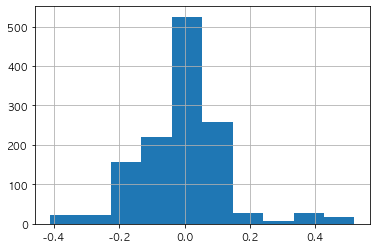

In [36]:
agg_data['중국지수_90일후_수익률'].hist()

### 미세먼지 감소 시, 중국지수가 평균적인 수준보다 더 강하게 하락한다고 볼 수 있음
### 중국지수 인버스에 활용가능할듯함 (근데 파나?)

### 동일한 실험 코스피로 진행

In [37]:
agg_data2 = fine_dust_data[['시그마', '미세먼지_증가']]

In [50]:
agg_data2.loc[:, '코스피'] = kospi['Close'].copy()
agg_data2.loc[:, '코스피'] = agg_data2['코스피'].fillna(method='ffill').copy() # 개장 안한날 Null값은 직전 데이터로 보정

In [51]:
for n in n_days:
    agg_data2.loc[:, '코스피_{}일후'.format(n)] = agg_data2['코스피'].shift(periods=-n).copy()

In [52]:
for n in n_days:
    agg_data2.loc[:, '코스피_{}일후_수익률'.format(n)] = \
        (agg_data2['코스피_{}일후'.format(n)] - agg_data2['코스피']) / agg_data2['코스피']

In [53]:
agg_data2 = agg_data2.dropna()

In [54]:
get_performance(agg_data2, sigma=1)

[1 시그마 이상 미세먼지 증가한 경우]
전체데이터 중 해당되는 케이스 비율:0.160 (191/1192)
====== 산술 수익률 ======
코스피_1일후_수익률: 0.000
코스피_3일후_수익률: 0.001
코스피_7일후_수익률: 0.001
코스피_10일후_수익률: 0.002
코스피_20일후_수익률: 0.001
코스피_30일후_수익률: -0.000
코스피_60일후_수익률: 0.008
코스피_90일후_수익률: 0.012
====== 기하 수익률 ======
코스피_1일후_수익률: 0.000
코스피_3일후_수익률: 0.001
코스피_7일후_수익률: 0.001
코스피_10일후_수익률: 0.002
코스피_20일후_수익률: -0.000
코스피_30일후_수익률: -0.001
코스피_60일후_수익률: 0.006
코스피_90일후_수익률: 0.009


In [55]:
get_performance(agg_data2, sigma=2)

[2 시그마 이상 미세먼지 증가한 경우]
전체데이터 중 해당되는 케이스 비율:0.058 (69/1192)
====== 산술 수익률 ======
코스피_1일후_수익률: 0.000
코스피_3일후_수익률: 0.000
코스피_7일후_수익률: 0.002
코스피_10일후_수익률: 0.005
코스피_20일후_수익률: 0.005
코스피_30일후_수익률: 0.004
코스피_60일후_수익률: 0.014
코스피_90일후_수익률: 0.011
====== 기하 수익률 ======
코스피_1일후_수익률: 0.000
코스피_3일후_수익률: 0.000
코스피_7일후_수익률: 0.001
코스피_10일후_수익률: 0.004
코스피_20일후_수익률: 0.004
코스피_30일후_수익률: 0.003
코스피_60일후_수익률: 0.012
코스피_90일후_수익률: 0.009


In [56]:
get_performance(agg_data2, sigma=3)

[3 시그마 이상 미세먼지 증가한 경우]
전체데이터 중 해당되는 케이스 비율:0.009 (11/1192)
====== 산술 수익률 ======
코스피_1일후_수익률: 0.003
코스피_3일후_수익률: 0.007
코스피_7일후_수익률: 0.010
코스피_10일후_수익률: 0.014
코스피_20일후_수익률: 0.012
코스피_30일후_수익률: 0.014
코스피_60일후_수익률: 0.034
코스피_90일후_수익률: 0.040
====== 기하 수익률 ======
코스피_1일후_수익률: 0.003
코스피_3일후_수익률: 0.007
코스피_7일후_수익률: 0.010
코스피_10일후_수익률: 0.014
코스피_20일후_수익률: 0.011
코스피_30일후_수익률: 0.013
코스피_60일후_수익률: 0.032
코스피_90일후_수익률: 0.037


### 상승케이스의 경우 중국과 비슷

In [57]:
agg_data2['코스피_90일후_수익률'].mean()

0.010885836449791199

In [58]:
hmean(1 + agg_data2['코스피_90일후_수익률']) - 1

0.008239227621128942

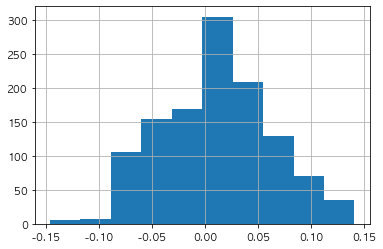

In [59]:
agg_data2['코스피_90일후_수익률'].hist()

In [60]:
get_performance(agg_data2, sigma=-1)

[-1 시그마 이하 미세먼지 하락한 경우]
전체데이터 중 해당되는 케이스 비율:0.151 (180/1192)
====== 산술 수익률 ======
코스피_1일후_수익률: 0.001
코스피_3일후_수익률: 0.003
코스피_7일후_수익률: 0.005
코스피_10일후_수익률: 0.005
코스피_20일후_수익률: 0.003
코스피_30일후_수익률: 0.005
코스피_60일후_수익률: 0.003
코스피_90일후_수익률: 0.005
====== 기하 수익률 ======
코스피_1일후_수익률: 0.000
코스피_3일후_수익률: 0.003
코스피_7일후_수익률: 0.005
코스피_10일후_수익률: 0.004
코스피_20일후_수익률: 0.003
코스피_30일후_수익률: 0.004
코스피_60일후_수익률: 0.001
코스피_90일후_수익률: 0.003


In [61]:
get_performance(agg_data2, sigma=-2)

[-2 시그마 이하 미세먼지 하락한 경우]
전체데이터 중 해당되는 케이스 비율:0.009 (11/1192)
====== 산술 수익률 ======
코스피_1일후_수익률: 0.004
코스피_3일후_수익률: 0.008
코스피_7일후_수익률: 0.013
코스피_10일후_수익률: 0.011
코스피_20일후_수익률: 0.009
코스피_30일후_수익률: 0.017
코스피_60일후_수익률: 0.007
코스피_90일후_수익률: 0.003
====== 기하 수익률 ======
코스피_1일후_수익률: 0.004
코스피_3일후_수익률: 0.008
코스피_7일후_수익률: 0.013
코스피_10일후_수익률: 0.010
코스피_20일후_수익률: 0.009
코스피_30일후_수익률: 0.016
코스피_60일후_수익률: 0.003
코스피_90일후_수익률: -0.001


### 하락케이스의 경우 크게 상관없는듯함